In [1]:
import torch
import torch.distributions as dist
import neml2
from pyzag import nonlinear, reparametrization, chunktime, stochastic
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA is available")
    print(f"CUDA version: {torch.version.cuda}")
else:
    dev = "cpu"
    print("CUDA is not available")
device = torch.device(dev)

CUDA is available
CUDA version: 12.8


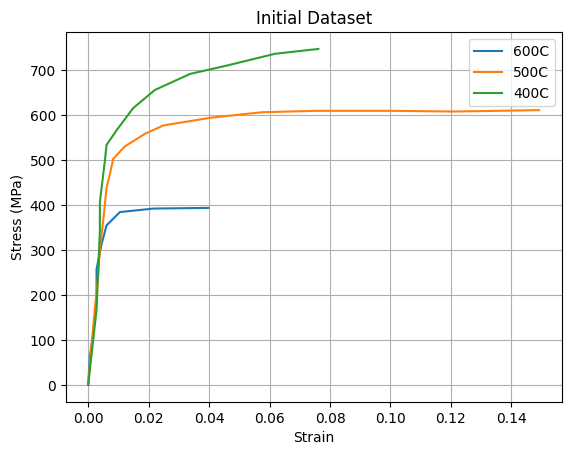

In [3]:
# Load experimental data
path = '/home/colinmoose/neml2/cmg_projects/tensile_data/var_temp'
data_frames = {}
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path)
        if '400' in filename:
            temp_label = '400'
        elif '500' in filename:
            temp_label = '500'
        elif '600' in filename:
            temp_label = '600'
        else:
            temp_label = 'unknown'
        
        new_df = df.rename(columns={'x':f'{temp_label}_strain', 'y':f'{temp_label}_stress'})
        data_frames[temp_label] = new_df

strain_data = {}
stress_data = {}

for temp_label, df in data_frames.items():
    strain_col = f'{temp_label}_strain'
    stress_col = f'{temp_label}_stress'
    strain = torch.tensor(df[strain_col].values, device=device)
    stress = torch.tensor(df[stress_col].values, device=device)
    max_stress_idx = torch.argmax(stress).item()
    strain = strain[:max_stress_idx + 1]
    stress = stress[:max_stress_idx + 1]
    strain = strain[:] - strain[0]
    stress = stress[:] - stress[0]
    strain_data[temp_label] = strain
    stress_data[temp_label] = stress

# Plot initial dataset
plt.figure()
for temp_label in strain_data:
    plt.plot(strain_data[temp_label].cpu().numpy(), stress_data[temp_label].cpu().numpy(), label=f"{temp_label}C")
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Initial Dataset')
plt.grid()
plt.legend()
plt.show()

In [4]:
nrate = 1
ntemperature = 3
nbatch = nrate * ntemperature
ntime = 100
rates = torch.tensor([1e-4], device=device)
temperatures = torch.linspace(400.0, 600.0, ntemperature, device=device)
print(f"--- Initial Experimental Conditions ---\nstrain rates:\n{rates}\ntemperatures:\n{temperatures}")

--- Initial Experimental Conditions ---
strain rates:
tensor([0.0001], device='cuda:0')
temperatures:
tensor([400., 500., 600.], device='cuda:0')


In [5]:
# Initialize tensors - we'll fill them based on each temperature's actual strain range
time = torch.zeros((ntime, nrate, ntemperature, 1), device=device)
loading = torch.zeros((ntime, nrate, ntemperature, 6), device=device)
temperature_tensor = torch.zeros((ntime, nrate, ntemperature, 1), device=device)

# For each temperature, use its actual experimental strain range
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    # Get the actual strain range from experimental data
    min_strain = strain_data[t_label].min().item()
    max_strain = strain_data[t_label].max().item()
    
    print(f"Temperature {t_label}C: strain range [{min_strain:.4f}, {max_strain:.4f}]")
    
    # Create loading (strain) values within this range
    strain_values = torch.linspace(min_strain, max_strain, ntime, device=device)
    loading[:, :, i, 0] = strain_values[:, None]
    
    # Calculate time based on strain rate
    for j, rate in enumerate(rates):
        time[:, j, i, 0] = strain_values / rate
    
    # Set temperature
    temperature_tensor[:, :, i, 0] = T

# Reshape for model
time = time.reshape((ntime, -1, 1))
temperature_tensor = temperature_tensor.reshape((ntime, -1, 1))
loading = loading.reshape((ntime, -1, 6))
print(f"\n--- Full Input Tensors ---\ntime:\n{time.shape}\ntemperature:\n{temperature_tensor.shape}\nloading:\n{loading.shape}")

Temperature 400C: strain range [0.0000, 0.0761]
Temperature 500C: strain range [0.0000, 0.1492]
Temperature 600C: strain range [0.0000, 0.0398]

--- Full Input Tensors ---
time:
torch.Size([100, 3, 1])
temperature:
torch.Size([100, 3, 1])
loading:
torch.Size([100, 3, 6])


Initial data size for 600:
torch.Size([10])
Initial data size for 500:
torch.Size([19])
Initial data size for 400:
torch.Size([13])
Interpolated data for 400C:
  Strain range: [0.0000, 0.0761]
  Stress range: [0.0000, 747.3888]
  Strain shape: torch.Size([100, 3, 6])
  Stress shape: torch.Size([100, 3, 6])

Interpolated data for 500C:
  Strain range: [0.0000, 0.1492]
  Stress range: [0.0000, 611.2186]
  Strain shape: torch.Size([100, 3, 6])
  Stress shape: torch.Size([100, 3, 6])

Interpolated data for 600C:
  Strain range: [0.0000, 0.0398]
  Stress range: [0.0000, 393.7984]
  Strain shape: torch.Size([100, 3, 6])
  Stress shape: torch.Size([100, 3, 6])



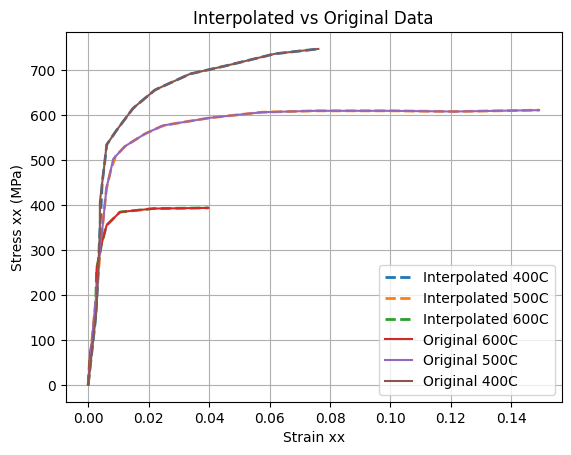

In [6]:
# Initial data shape
for temp_label in stress_data:
    print(f"Initial data size for {temp_label}:\n{stress_data[temp_label].shape}")

exp_stress_data = torch.zeros_like(loading, device=device)
exp_strain_data = torch.zeros_like(loading, device=device)

for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    
    # Create interpolation functions
    f_stress = interp1d(strain_data[t_label].cpu().numpy(), 
                       stress_data[t_label].cpu().numpy(), 
                       kind='linear')
    
    # Interpolate at the loading points (which are already within experimental range)
    exp_stress_data[:, i, 0] = torch.tensor(f_stress(loading[:, i, 0].cpu().numpy()), device=device)
    exp_strain_data[:, i, 0] = loading[:, i, 0]  # These are the actual strain values
    
    print(f"Interpolated data for {t_label}C:")
    print(f"  Strain range: [{exp_strain_data[:, i, 0].min():.4f}, {exp_strain_data[:, i, 0].max():.4f}]")
    print(f"  Stress range: [{exp_stress_data[:, i, 0].min():.4f}, {exp_stress_data[:, i, 0].max():.4f}]")
    print(f"  Strain shape: {exp_strain_data.shape}")
    print(f"  Stress shape: {exp_stress_data.shape}\n")

# Plot interpolated data
plt.figure()
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), exp_stress_data[:, i, 0].cpu().numpy(), '--',
               label=f"Interpolated {t_label}C", linewidth=2)
for temp_label in strain_data:
    plt.plot(strain_data[temp_label].cpu().numpy(), stress_data[temp_label].cpu().numpy(),
            label=f"Original {temp_label}C")
plt.xlabel("Strain xx")
plt.ylabel("Stress xx (MPa)")
plt.title("Interpolated vs Original Data")
plt.grid()
plt.legend()
plt.show()

In [7]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """

    def __init__(self, discrete_equations, nchunk=1, rtol=1.0e-6, atol=1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            temperature (torch.tensor): batched temperatures
            loading (torch.tensor): loading conditions, which are the input strain in the first base index and then the stress (zero) in the remainder
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations,
            step_generator=nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(),
            nonlinear_solver=chunktime.ChunkNewtonRaphson(rtol=self.rtol, atol=self.atol),
        )
        
        control = torch.zeros_like(loading)
        control[...,1:] = 1.0

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable(
            {
                "forces/t": time,
                "forces/control": control,
                "forces/T": temperature,
                "forces/fixed_values": loading
            }
        ).torch()
        state0 = torch.zeros(
            forces.shape[1:-1] + (self.discrete_equations.nstate,), device=forces.device
        )

        result = nonlinear.solve_adjoint(solver, state0, len(forces), forces)
        
        # Check if result is empty or invalid
        if result is None or len(result) == 0:
            raise RuntimeError("Solver returned empty result - integration failed")

        return result[...,0:1]

In [8]:
nchunk = 50
nmodel = neml2.load_model("test_model2.i", "implicit_rate")
nmodel.to(device = device)
print(nmodel)
model = SolveStrain(neml2.pyzag.NEML2PyzagModel(nmodel,exclude_parameters = ["E_X", "E_Y", "elasticity_nu", "R_X", "d_X", "sy_X", "mu_X", "n_X"]), nchunk=nchunk)

Name:       implicit_rate
Input:      forces/T [Scalar]
            forces/control [SR2]
            forces/fixed_values [SR2]
            forces/t [Scalar]
            old_forces/control [SR2]
            old_forces/fixed_values [SR2]
            old_forces/t [Scalar]
            old_state/internal/ep [Scalar]
            old_state/mixed_state [SR2]
            state/internal/ep [Scalar]
            state/mixed_state [SR2]
Output:     residual/internal/ep [Scalar]
            residual/mixed_state [SR2]
Parameters: E_X [Scalar][Double][cuda:0]
            E_Y [Scalar][Double][cuda:0]
            R_X [Scalar][Double][cuda:0]
            R_Y [Scalar][Double][cuda:0]
            d_X [Scalar][Double][cuda:0]
            d_Y [Scalar][Double][cuda:0]
            elasticity_nu [Scalar][Double][cuda:0]
            mu_X [Scalar][Double][cuda:0]
            mu_Y [Scalar][Double][cuda:0]
            n_X [Scalar][Double][cuda:0]
            n_Y [Scalar][Double][cuda:0]
            sy_X [Scalar][Do

Temp 400C: E = 68000.0 MPa, E_exp = 68782.02 MPa
yield stress: 542.22 MPa at strain: 0.0069
Temp 500C: E = 72000.0 MPa, E_exp = 72605.39 MPa
yield stress: 507.30 MPa at strain: 0.0090
Temp 600C: E = 66000.0 MPa, E_exp = 66822.67 MPa
yield stress: 364.18 MPa at strain: 0.0074

Experimental E values: [68782.02001514 72605.39007092 66822.6744186 ]
Experimental sy values: [542.21909618 507.29530807 364.18269926]
Updated E: tensor([68782.0200, 72605.3901, 66822.6744], device='cuda:0')
Updated sy: tensor([542.2191, 507.2953, 364.1827], device='cuda:0', requires_grad=True)


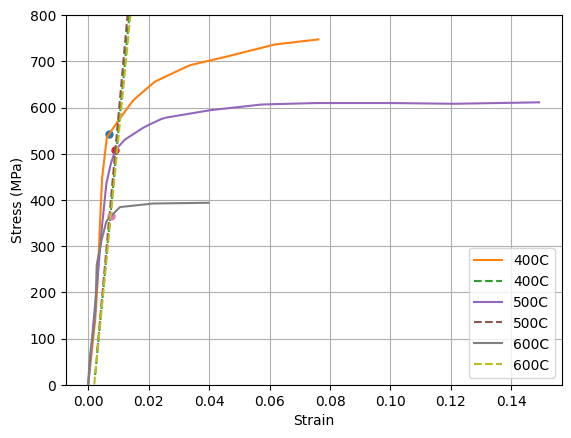

In [9]:
# Find the yield stress for each temperature
E = nmodel.E_Y.tensor().torch() # current Young's Modulus for model
sy = nmodel.sy_Y.tensor().torch()
offset = 0.002

sy_exps = []
E_exps = []

for i, T in enumerate(temperatures):
    temp_label = str(int(T.item()))

    # Calculate actual experimental Young's Modulues 
    strain_initial = exp_strain_data[:5, i, 0].cpu().numpy()
    stress_initial = exp_stress_data[:5, i, 0].cpu().numpy()
    E_exp = np.polyfit(strain_initial, stress_initial, 1)[0]
    E_exps.append(E_exp)
    print(f"Temp {temp_label}C: E = {E[i]} MPa, E_exp = {E_exp:.2f} MPa")

    # Grab experimental data and convert to numpy arrays for easier data handling
    stress_exp = exp_stress_data[:, i, 0].cpu().numpy()
    strain_range = exp_strain_data[:, i, 0].cpu().numpy()
    

    # Create offset lines for each temperature and ensure they start at (0.002, 0)
    valid_idx = strain_range >= offset
    stress_offset = np.zeros_like(strain_range)
    stress_offset[valid_idx] = E_exp * (strain_range[valid_idx] - offset) # Hooke's Law

    min_stress_threshold = 300
    search_idx = (strain_range >= 0.004) & (stress_offset >=min_stress_threshold)
    if search_idx.any():
        diff = stress_exp[search_idx] - stress_offset[search_idx]
        crossing_idx = np.where(diff >= 0)[0]
        if len(crossing_idx) > 0:
            idx = np.where(search_idx)[0][crossing_idx[0]]

            if idx > 0:
                start_idx = max(0, idx - 3)
                end_idx = min(len(strain_range), idx + 3)

                strain_local = strain_range[start_idx:end_idx]
                stress_exp_local = stress_exp[start_idx:end_idx]
                stress_offset_local = stress_offset[start_idx:end_idx]

                f_exp = interp1d(strain_local, stress_exp_local, kind='linear')
                f_offset = interp1d(strain_local, stress_offset_local, kind='linear')

                strain_fine = np.linspace(strain_local[0], strain_local[-1], 1000)
                diff_fine = f_exp(strain_fine) - f_offset(strain_fine)
                sign_changes = np.where(np.diff(np.sign(diff_fine)))[0]
                if len(sign_changes) > 0:
                    yield_strain = strain_fine[sign_changes[0]]
                    yield_stress = f_exp(yield_strain)
                else:
                    yield_strain = strain_range[idx]
                    yield_stress = stress_exp[idx]
            else:
                yield_strain = strain_range[idx]
                yield_stress = stress_exp[idx]

            sy_exps.append(yield_stress)
            print(f"yield stress: {yield_stress.item():.2f} MPa at strain: {yield_strain.item():.4f}")
            plt.plot(yield_strain, yield_stress, 'o', markersize=5)

    # experimental curves
    plt.plot(strain_range, stress_exp, '-', label=f"{temp_label}C")
    # offset lines only where valid
    plt.plot(strain_range[valid_idx], stress_offset[valid_idx], "--", label=f"{temp_label}C")
    plt.xlabel('Strain')
    plt.ylabel('Stress (MPa)')
    plt.legend()
    plt.grid()
    plt.ylim((0.0, 800.0))

# Replace model parameters with experimental values to improve training
E_exps = np.array(E_exps)
sy_exps = np.array(sy_exps)
print(f"\nExperimental E values: {E_exps}")
print(f"Experimental sy values: {sy_exps}")

E_tensor = torch.tensor(E_exps, device=device, dtype=torch.double)
sy_tensor = torch.tensor(sy_exps, device=device, dtype=torch.double)

with torch.no_grad():
    E_param = nmodel.E_Y.tensor().torch()
    sy_param = nmodel.sy_Y.tensor().torch()
    E_param.copy_(E_tensor)
    sy_param.copy_(sy_tensor)
    print(f"Updated E: {nmodel.E_Y.tensor().torch()}")
    print(f"Updated sy: {nmodel.sy_Y.tensor().torch()}")

In [10]:
actual_noise_scale = 10.0
n_repeat = 100
noisy_exp_stress_data = torch.stack([torch.normal(exp_stress_data, actual_noise_scale) for _ in range(n_repeat)])

Text(0.5, 1.0, 'Experimental Dataset with Artificial Noise -- All Conditions')

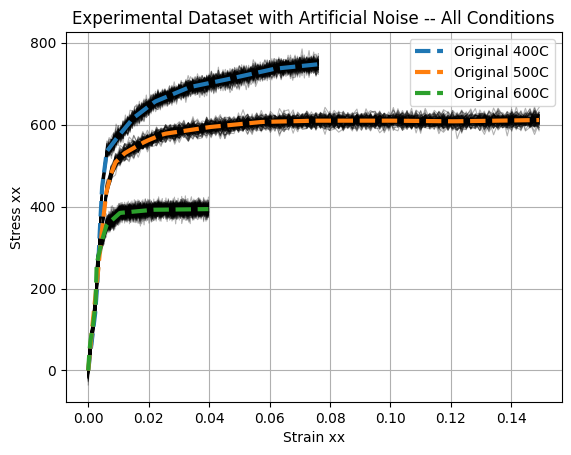

In [11]:
for repeat_idx in range(n_repeat):
    for i, T in enumerate(temperatures):
        t_label = str(int(T.item()))
        plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), noisy_exp_stress_data[repeat_idx, :, i, 0].cpu().numpy(), color='k', alpha=0.3, lw=0.8)
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), exp_stress_data[:, i, 0].cpu().numpy(),'--', lw=3, color=f'C{i}', label=f'Original {t_label}C')
plt.xlabel("Strain xx")
plt.ylabel("Stress xx")
plt.legend()
plt.grid()
plt.title("Experimental Dataset with Artificial Noise -- All Conditions")

In [12]:
R_scaler = reparametrization.RangeRescale(torch.tensor([0.01, 0.01, 0.01], device=device), torch.tensor([500.0, 500.0, 500.0], device=device))
d_scaler = reparametrization.RangeRescale(torch.tensor([0.01, 0.01, 0.01], device=device), torch.tensor([50.0, 50.0, 50.0], device=device))
mu_scaler = reparametrization.RangeRescale(torch.tensor([1.0, 1.0, 1.0], device=device), torch.tensor([500.0, 500.0, 500.0], device=device))
n_scaler = reparametrization.RangeRescale(torch.tensor([0.01, 0.01, 0.01], device=device), torch.tensor([50.0, 50.0, 50.0], device=device))
sy_scaler = reparametrization.RangeRescale(torch.tensor([350.0, 350.0, 350.0], device=device), torch.tensor([600.0, 600.0, 600.0], device=device))

model_reparameterizer = reparametrization.Reparameterizer(
    {"discrete_equations.R_Y": R_scaler,
     "discrete_equations.d_Y": d_scaler,
     "discrete_equations.mu_Y": mu_scaler,
     "discrete_equations.n_Y": n_scaler,
     "discrete_equations.sy_Y": sy_scaler}, error_not_provided=True)

print(f'--- Before Reparameterization ---')
original_parameter_values_simple = {}
for n, p in model.named_parameters():
    original_parameter_values_simple[n] = p.data.detach().clone()
    print(f"{n}: Original physical value = {p.data}")

model_reparameterizer(model)

print(f'--- After Reparameterization ---')
original_parameter_values = {}
for n, p in model.named_parameters():
    parts = n.split(".")
    if "parametrizations" in parts:
        param_idx = parts.index("parametrizations")
        simple_name = parts[param_idx - 1] + "." + parts[param_idx + 1]
    else:
        simple_name = '.'.join(parts[1:])
    if simple_name and original_parameter_values_simple:
        original_parameter_values[n] = original_parameter_values_simple[simple_name]

    print(f"{n}: Reparameterized value = {p.data}")

--- Before Reparameterization ---
discrete_equations.R_Y: Original physical value = tensor([300., 200., 100.], device='cuda:0')
discrete_equations.d_Y: Original physical value = tensor([30., 20., 15.], device='cuda:0')
discrete_equations.mu_Y: Original physical value = tensor([300., 200., 100.], device='cuda:0')
discrete_equations.n_Y: Original physical value = tensor([2., 2., 2.], device='cuda:0')
discrete_equations.sy_Y: Original physical value = tensor([542.2191, 507.2953, 364.1827], device='cuda:0')
--- After Reparameterization ---
discrete_equations.parametrizations.R_Y.original: Reparameterized value = tensor([0.6000, 0.4000, 0.2000], device='cuda:0')
discrete_equations.parametrizations.d_Y.original: Reparameterized value = tensor([0.5999, 0.3999, 0.2999], device='cuda:0')
discrete_equations.parametrizations.mu_Y.original: Reparameterized value = tensor([0.5992, 0.3988, 0.1984], device='cuda:0')
discrete_equations.parametrizations.n_Y.original: Reparameterized value = tensor([0.0

In [13]:
prior_cov = 0.05
prior_noise_scale = 10.0

mapper = stochastic.MapNormal(prior_cov)
hsmodel = stochastic.HierarchicalStatisticalModel(model, mapper, torch.tensor(prior_noise_scale, device = device))

In [14]:
nreps = 5
predict = Predictive(hsmodel, num_samples=nreps)
with torch.no_grad():
    untrained_all = predict(time, temperature_tensor, loading, )["obs"]

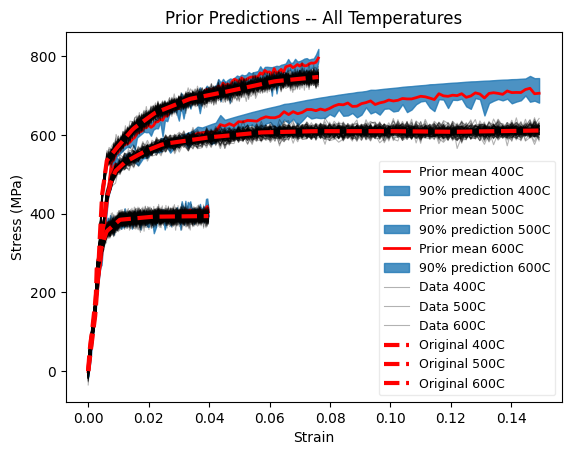

In [15]:
plt.figure()
plotted_labels = set()
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    temp_preds = untrained_all[:, :, i, 0]
    plt.plot(loading[:, i, 0].cpu(), temp_preds.mean(dim=0).cpu(),
        ls="-",
        color="r",
        lw=2,
        label=f"Prior mean {t_label}C",
    )

    p = 0.05
    n_lb = max(1, int(p * nreps))
    n_ub = max(nreps, int((1 - p) * nreps) + 1)
    plt.fill_between(
        loading[:, i, 0].cpu(),
        torch.kthvalue(temp_preds, n_lb, dim=0)[0].cpu(),
        torch.kthvalue(temp_preds, n_ub, dim=0)[0].cpu(),
        color="tab:blue",
        alpha=0.8,
        label=f"90% prediction {t_label}C",
    )
for repeat_idx in range(n_repeat):
    for i, T in enumerate(temperatures):
        t_label = str(int(T.item()))
        label = f"Data {t_label}C" if f"Data {t_label}C" not in plotted_labels else None
        if label:
            plotted_labels.add(label)
        plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), noisy_exp_stress_data[repeat_idx, :, i, 0].cpu().numpy(), 
                    color='k', alpha=0.3, lw=0.8, label=label)
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), exp_stress_data[:, i, 0].cpu().numpy(),'--', lw=3, color='r', label=f'Original {t_label}C')


plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Prior Predictions -- All Temperatures")
plt.legend(loc="best", framealpha=0.4, fontsize=9)
plt.show()

In [16]:
guide = pyro.infer.autoguide.guides.AutoDelta(hsmodel)
lr = 1.0e-5
niter = 2000
num_samples = 1

optimizer = pyro.optim.ClippedAdam({'lr': lr})
loss = Trace_ELBO(num_particles=num_samples)
svi = SVI(hsmodel, guide, optimizer, loss = loss)

Loss: 5.86e+06: : 100%|█████████▉|1996/2000/home/colinmoose/miniforge/envs/neml2/lib/python3.13/site-packages/pyzag/chunktime.py:114: UserWarning: Implicit solve did not succeed.  Results may be inaccurate...
  warnings.warn(
Loss: 5.85e+06: : 100%|██████████|2000/2000


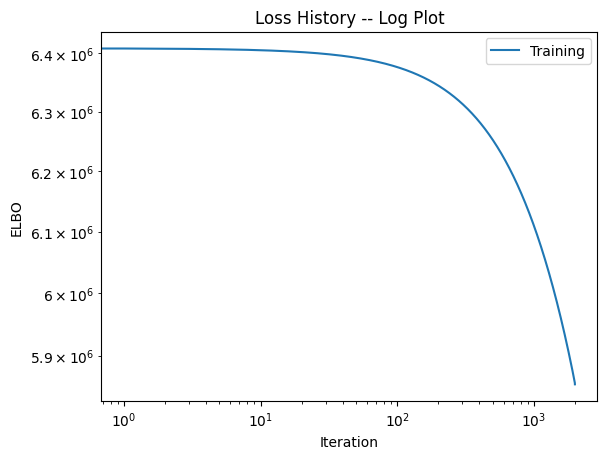

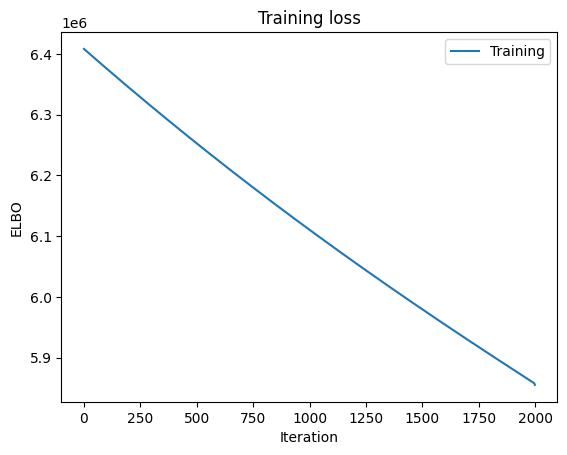

In [17]:
titer = tqdm.tqdm(
    range(niter),
    bar_format="{desc}: {percentage:3.0f}%|{bar}|{n_fmt}/{total_fmt}{postfix}",
)
titer.set_description("Loss:")
loss_history = []
for i in titer:
    closs = svi.step(time, temperature_tensor, loading, results=noisy_exp_stress_data.mean(dim=0))
    loss_history.append(closs)
    titer.set_description("Loss: %3.2e" % closs)

plt.figure()
plt.loglog(loss_history, label='Training')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.legend(loc='best')
plt.title('Loss History -- Log Plot')

plt.figure()
plt.plot(loss_history, label="Training")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(loc="best")
plt.title("Training loss")
plt.show()

In [18]:
nreps = 5
predict = Predictive(hsmodel, guide=guide, num_samples=nreps)
with torch.no_grad():
    trained_all = predict(time, temperature_tensor, loading, )["obs"]

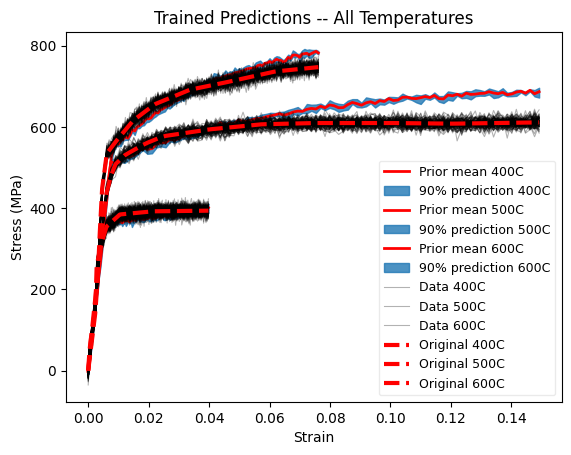

In [19]:
plt.figure()
plotted_labels = set()
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    temp_preds = trained_all[:, :, i, 0]
    plt.plot(loading[:, i, 0].cpu(), temp_preds.mean(dim=0).cpu(),
        ls="-",
        color="r",
        lw=2,
        label=f"Prior mean {t_label}C",
    )

    p = 0.05
    n_lb = max(1, int(p * nreps))
    n_ub = max(nreps, int((1 - p) * nreps) + 1)
    plt.fill_between(
        loading[:, i, 0].cpu(),
        torch.kthvalue(temp_preds, n_lb, dim=0)[0].cpu(),
        torch.kthvalue(temp_preds, n_ub, dim=0)[0].cpu(),
        color="tab:blue",
        alpha=0.8,
        label=f"90% prediction {t_label}C",
    )
for repeat_idx in range(n_repeat):
    for i, T in enumerate(temperatures):
        t_label = str(int(T.item()))
        label = f"Data {t_label}C" if f"Data {t_label}C" not in plotted_labels else None
        if label:
            plotted_labels.add(label)
        plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), noisy_exp_stress_data[repeat_idx, :, i, 0].cpu().numpy(), 
                    color='k', alpha=0.3, lw=0.8, label=label)
for i, T in enumerate(temperatures):
    t_label = str(int(T.item()))
    plt.plot(exp_strain_data[:, i, 0].cpu().numpy(), exp_stress_data[:, i, 0].cpu().numpy(),'--', lw=3, color='r', label=f'Original {t_label}C')


plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Trained Predictions -- All Temperatures")
plt.legend(loc="best", framealpha=0.4, fontsize=9)
plt.show()

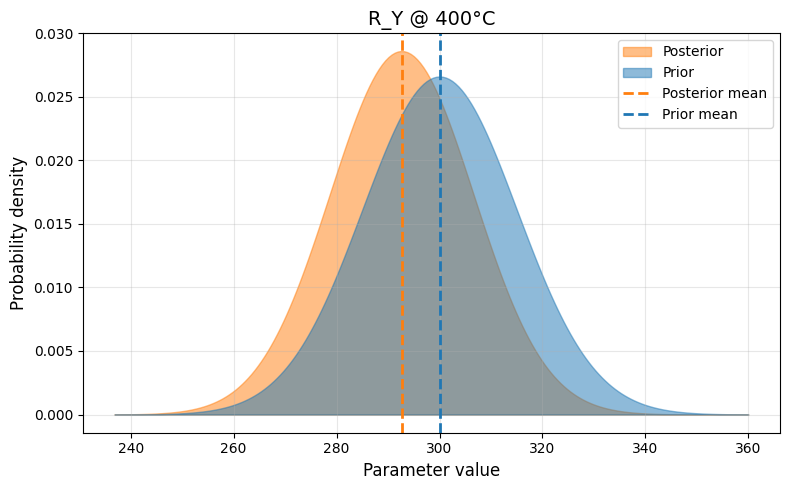

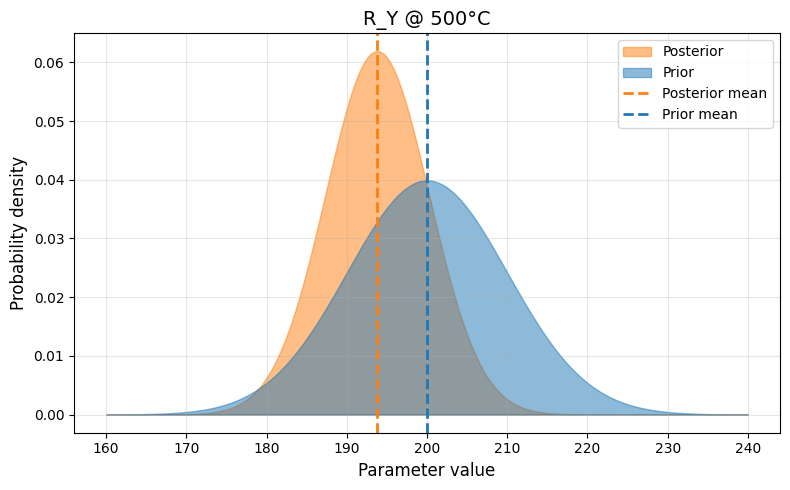

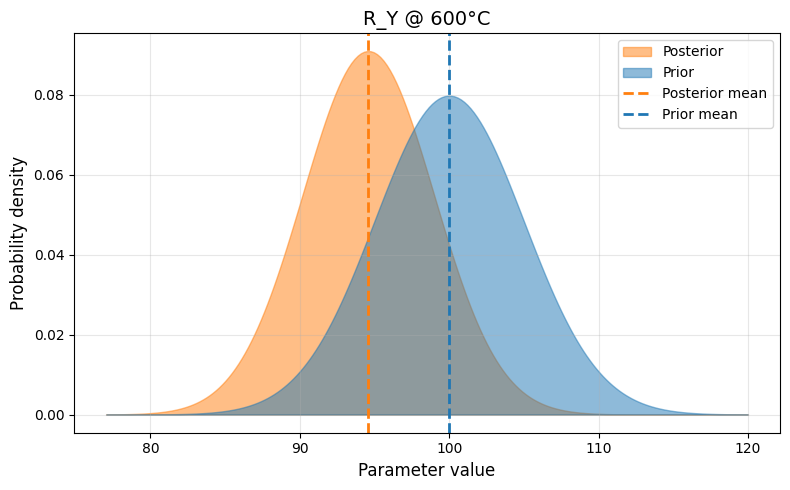

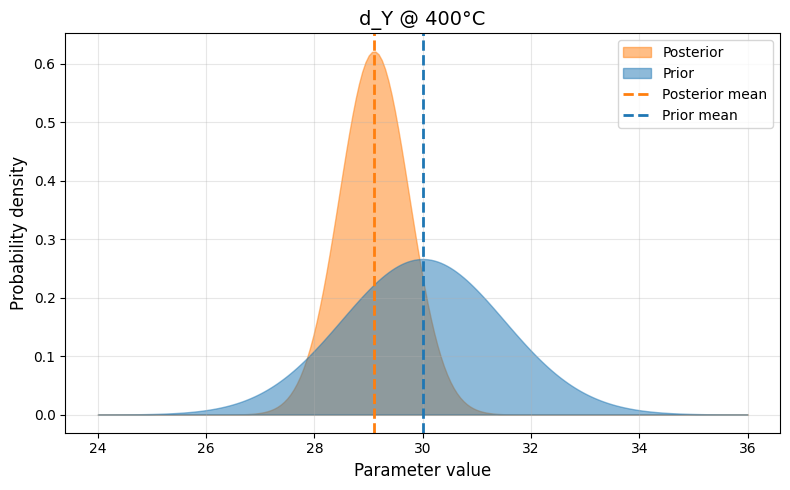

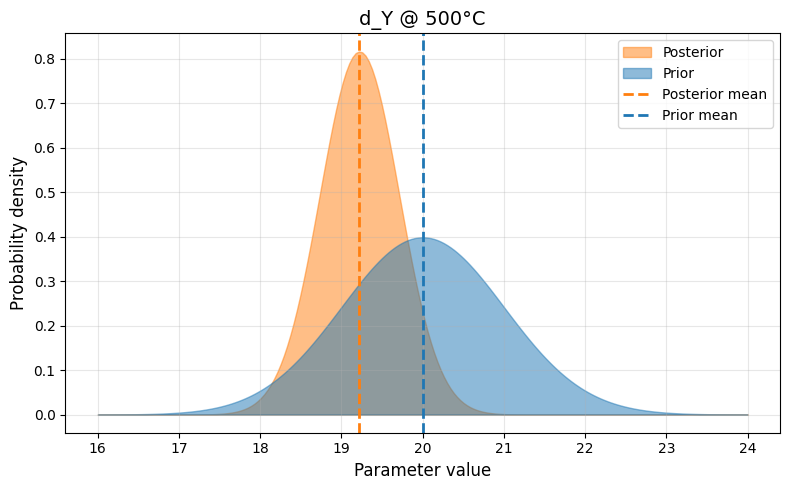

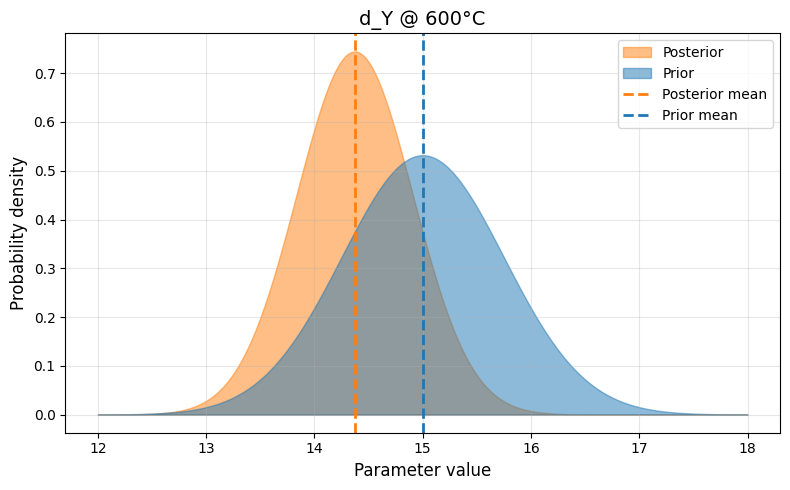

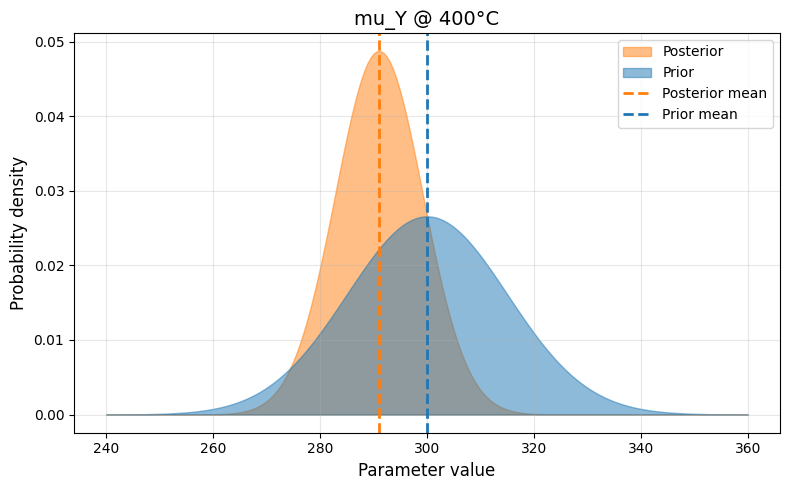

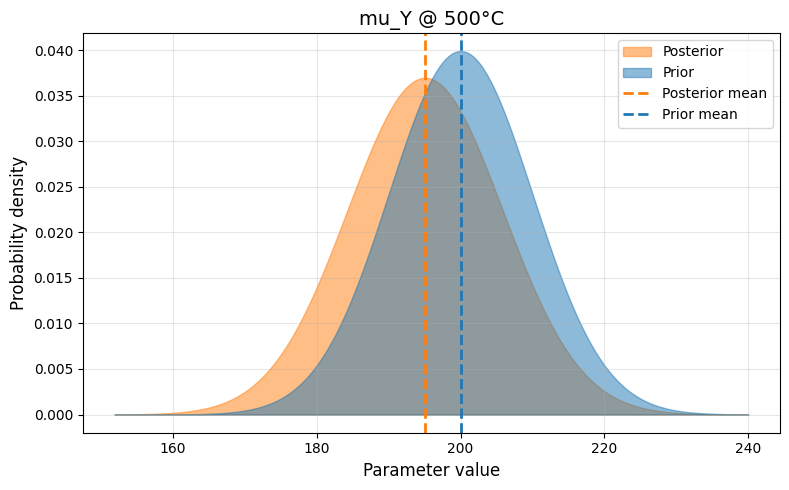

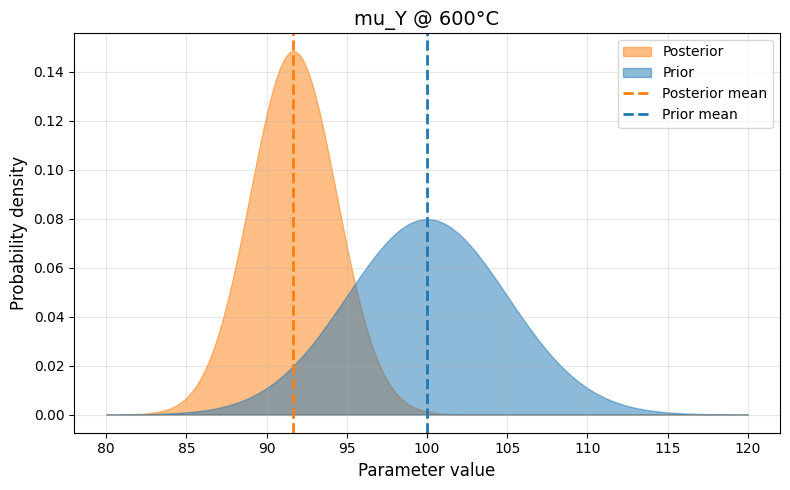

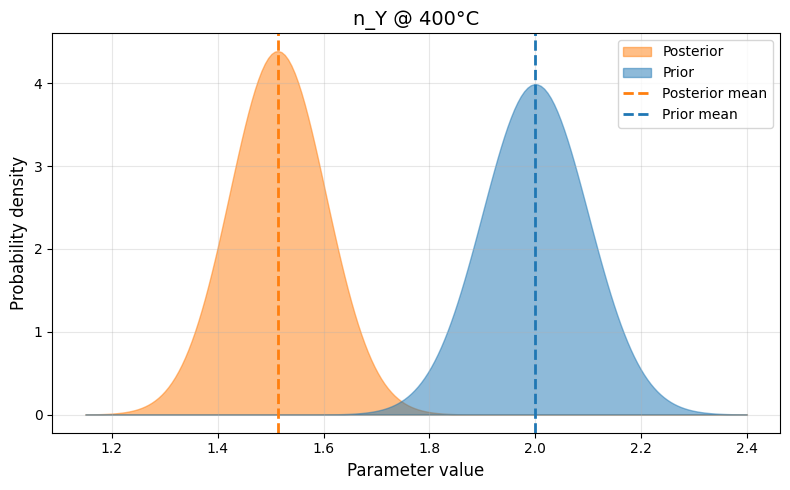

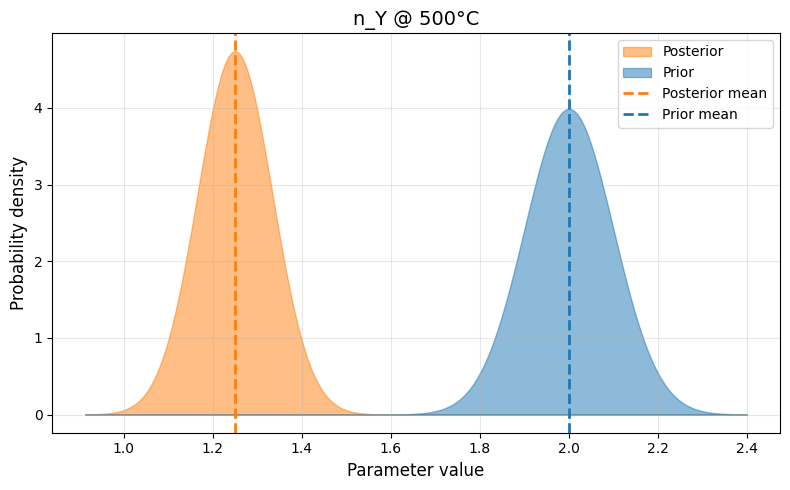

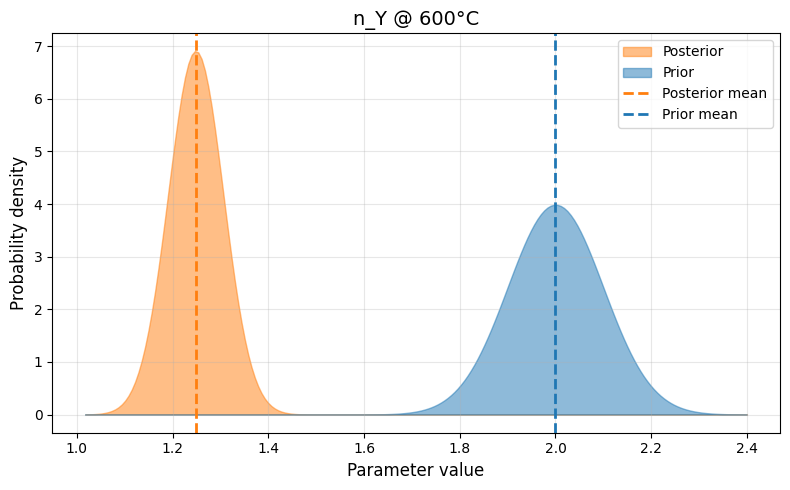

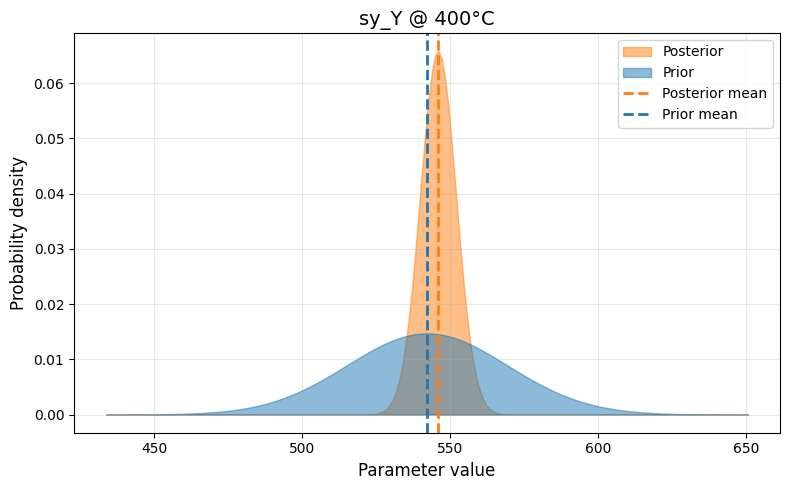

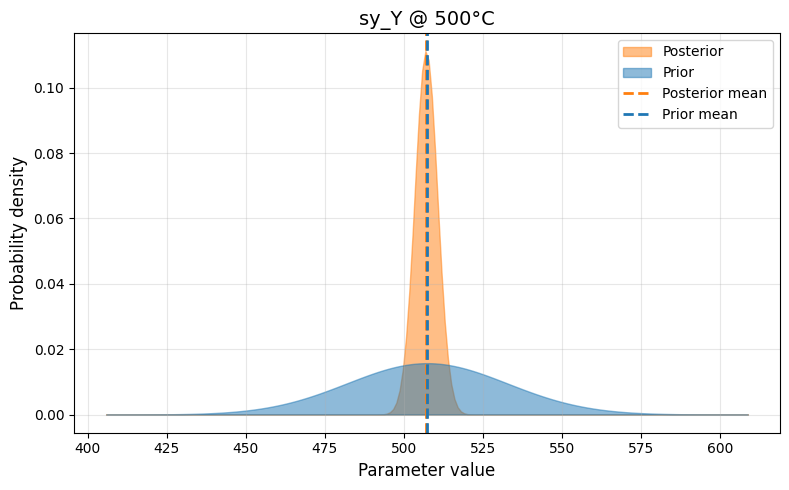

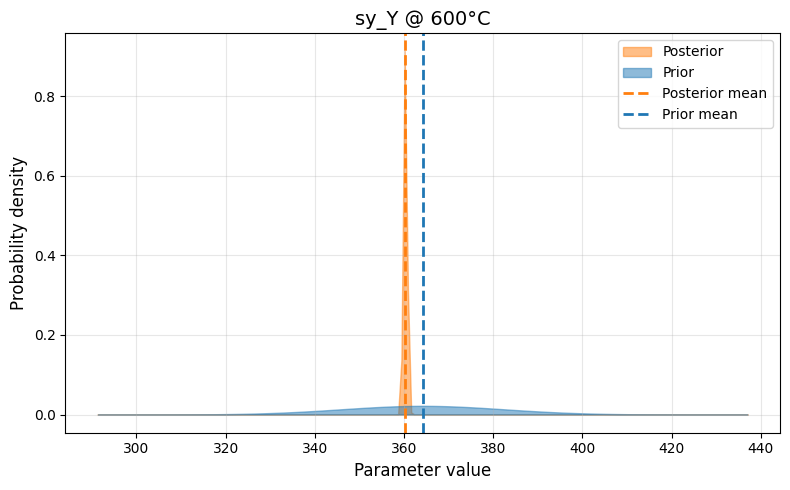

In [20]:
for _,_,n in hsmodel.bot:
    # Handle parametrized names - extract base parameter name
    # n looks like: "model.discrete_equations.parametrizations.R_Y.original"
    # We need: "discrete_equations.R_Y"
    
    parts = n.split(".")
    if "parametrizations" in parts:
        # Remove "model", "parametrizations", and "original"
        # Keep "discrete_equations" and parameter name (e.g., "R_Y")
        param_idx = parts.index("parametrizations")
        simple_name = parts[param_idx - 1] + "." + parts[param_idx + 1]  # "discrete_equations.R_Y"
    else:
        # Fallback for non-parametrized names
        simple_name = '.'.join(parts[1:])
    
    scaler = model_reparameterizer.map_dict[simple_name]
    prior_loc = original_parameter_values[n].to(device)
    prior_scale = prior_cov * torch.abs(prior_loc)

    posterior_loc = scaler.forward(pyro.param("AutoDelta." + n + "_loc").detach())
    posterior_scale = scaler.forward_std_dev(pyro.param("AutoDelta." + n + "_scale").detach())

    # Extract just the parameter name for cleaner titles
    param_name = simple_name.split('.')[-1]  # e.g., "R_Y"

    if posterior_loc.dim() == 0:
        # Scalar parameter
        x_range = torch.linspace(
            min(posterior_loc - 4*posterior_scale, prior_loc - 4*prior_scale), 
            max(posterior_loc + 4*posterior_scale, prior_loc + 4*prior_scale), 
            200, device=device
        )
        y_posterior = dist.Normal(posterior_loc, posterior_scale).log_prob(x_range).exp()
        y_prior = dist.Normal(prior_loc, prior_scale).log_prob(x_range).exp()
        
        plt.figure(figsize=(8, 5))
        plt.fill_between(x_range.cpu(), y_posterior.cpu(), label="Posterior", alpha=0.5, color='C1')
        plt.fill_between(x_range.cpu(), y_prior.cpu(), label="Prior", alpha=0.5, color='C0')
        plt.axvline(posterior_loc.cpu(), color='C1', linestyle='--', linewidth=2, label='Posterior mean')
        plt.axvline(prior_loc.cpu(), color='C0', linestyle='--', linewidth=2, label='Prior mean')
        plt.xlabel('Parameter value', fontsize=12)
        plt.ylabel('Probability density', fontsize=12)
        plt.legend(loc='best', fontsize=10)
        plt.title(f'{param_name}', fontsize=14)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        # Vector parameter - one plot per temperature
        temp_labels = ['400°C', '500°C', '600°C']
        for i in range(posterior_loc.shape[0]):
            x_range = torch.linspace(
                min(posterior_loc[i] - 4*posterior_scale[i], prior_loc[i] - 4*prior_scale[i]), 
                max(posterior_loc[i] + 4*posterior_scale[i], prior_loc[i] + 4*prior_scale[i]), 
                200, device=device
            )
            y_posterior = dist.Normal(posterior_loc[i], posterior_scale[i]).log_prob(x_range).exp()
            y_prior = dist.Normal(prior_loc[i], prior_scale[i]).log_prob(x_range).exp()
            
            plt.figure(figsize=(8, 5))
            plt.fill_between(x_range.cpu(), y_posterior.cpu(), label="Posterior", alpha=0.5, color='C1')
            plt.fill_between(x_range.cpu(), y_prior.cpu(), label="Prior", alpha=0.5, color='C0')
            plt.axvline(posterior_loc[i].cpu(), color='C1', linestyle='--', linewidth=2, label='Posterior mean')
            plt.axvline(prior_loc[i].cpu(), color='C0', linestyle='--', linewidth=2, label='Prior mean')
            plt.xlabel('Parameter value', fontsize=12)
            plt.ylabel('Probability density', fontsize=12)
            plt.legend(loc='best', fontsize=10)
            plt.title(f'{param_name} @ {temp_labels[i]}', fontsize=14)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()